### Classical Base Model: MNIST Data

Here, we experiment with a model with basic CNN layers and classical contrastive pair loss to make the model predict whether 2 images belong to the same class or different class.

We will make pairs of images, if they belong to the same class the label will be set to 1, otherwise 0. The model's goal will be to predict the label correctly.

We will consider only images of 0 and 1 from MNIST dataset, as the datasets we will use later on are also binary (electron-photon or quark-gluon)

In [1]:
# Required Imports
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import confusion_matrix as cmatrix
from tensorflow.keras import layers, models, losses, optimizers
import pandas as pd
import itertools
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

In [2]:
tf.random.set_seed(42)

### Data Loading and Pre-processing

In [3]:
# loading the data as train and test
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000,) (10000,)


In [4]:
# Filter for only 9 and 6 from all the digits
def filter_labels(images, labels):
    filter_mask = np.isin(labels, [3, 8])
    return images[filter_mask], labels[filter_mask]

In [5]:
x_train, y_train = filter_labels(x_train, y_train)
x_test, y_test = filter_labels(x_test, y_test)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(11982, 28, 28) (1984, 28, 28)
(11982,) (1984,)


In [6]:
# Preprocess the dataset
def preprocess_data(images, labels):
    images = np.expand_dims(images, -1)  # Add channel dimension
    images = images.astype('float32') / 255.0  # Normalize
    return images, labels

In [7]:
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(11982, 28, 28, 1) (1984, 28, 28, 1)
(11982,) (1984,)


In [8]:
# Saving the data as npz
np.savez_compressed('../../data/mnist38.npz', **{
    'x_train': x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test
})

### Defining the Model

In [9]:
# Create pairs of images and labels
def create_pairs(images, labels):
    pairs = []
    pair_labels = []

    num_classes = len(np.unique(labels)) # 2
    digit_indices = [np.where(labels == i)[0] for i in [3,8]]
    # print(digit_indices)

    for idx1 in range(len(images)):
        x1, label1 = images[idx1], labels[idx1]
        if label1==3:
            l1=0
        else:
            l1=1
        idx2 = np.random.choice(digit_indices[l1])
        x2 = images[idx2]

        # if x1==x2, label set to 1
        pairs.append([x1, x2])
        pair_labels.append(1)

        # if x1!=x2, label set to 0
        # label2 = (label1 + np.random.randint(1, num_classes)) % num_classes
        if label1==3:
            l2=1
        else:
            l2=0
        idx2 = np.random.choice(digit_indices[l2])
        x2 = images[idx2]
        pairs.append([x1, x2])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

In [10]:
pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape,labels_test.shape)

(23964, 2, 28, 28, 1) (3968, 2, 28, 28, 1)
(23964,) (3968,)


In [11]:
def plot_sample_pairs(pairs, labels, num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(pairs[i, 0].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(pairs[i, 1].reshape(28, 28), cmap='gray')
        ax.axis('off')

        label = labels[i]
        plt.title(f'Sample: {i}, Label: {label}')

    plt.tight_layout()
    plt.show()

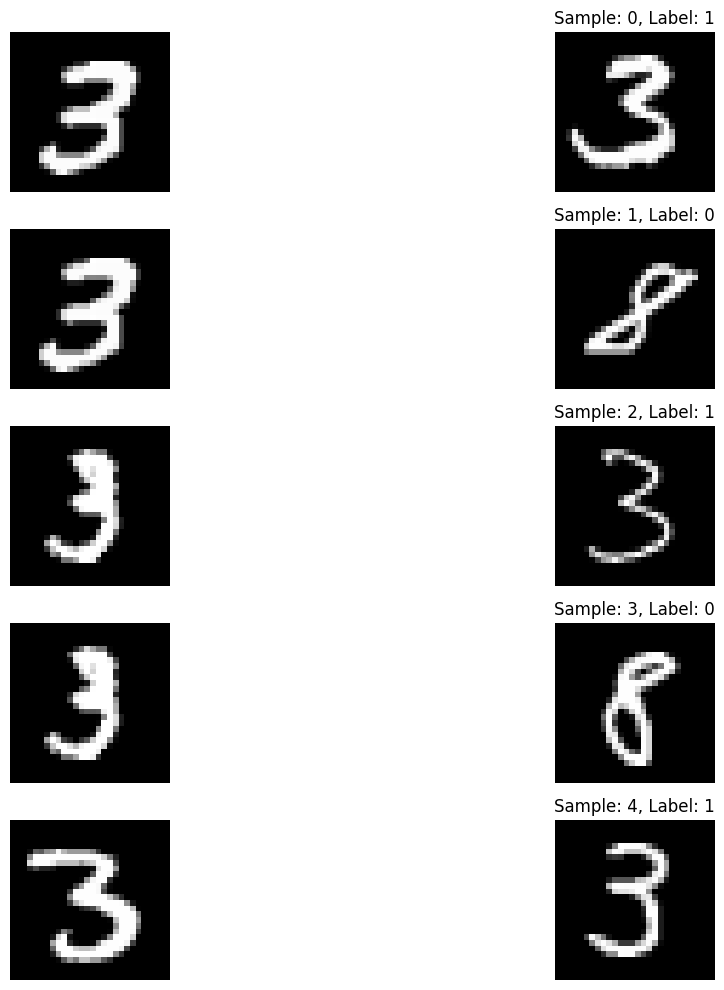

In [12]:
plot_sample_pairs(pairs_train, labels_train)

## Contrastive Pair Loss

The contrastive pair loss is used to learn representations by contrasting positive and negative pairs of samples. 

The formula is given by:

$$
L = \frac{1}{2N} \sum_{i=1}^{N} \left[ y_i \cdot d_i^2 + (1 - y_i) \cdot \max(margin - d_i, 0)^2 \right]
$$

where:

- **L** is the contrastive loss
- **N** is the number of pairs
- **$y_i$** is a binary label indicating whether the pair ($x_i$, $x_j$) is a positive pair (1) or a negative pair (0)
- **$d_i$** is the distance between the embeddings of the pair ($x_i$, $x_j$)
- **margin** is a predefined margin

In this formula:

- For positive pairs $y_i$ = 1, the loss encourages the distance $d_i$ to be small
- For negative pairs $y_i$ = 0, the loss encourages the distance $d_i$ to be larger than the margin

This helps in clustering positive pairs together and pushing negative pairs apart when creating their embeddings


In [13]:
# Contrastive loss function based on margin
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

def training_accuracy():
    def accuracy(y_true, distance, threshold=0.5):
        y_pred_binary = tf.cast(distance <= threshold, tf.int32)
        true_positives = tf.reduce_sum(tf.cast((y_true == 1) & (y_pred_binary == 1), tf.float32))
        true_negatives = tf.reduce_sum(tf.cast((y_true == 0) & (y_pred_binary == 0), tf.float32))
        accuracy = (true_positives + true_negatives) / tf.cast(tf.size(y_true), tf.float32)
        return accuracy
    return accuracy

In [14]:
# Define the CNN model 
def create_base_model(input_shape, return_embeddings=False):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))  # Conv layer 1
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))  # Conv layer 2
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    if return_embeddings:
        return model
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    return model

## Siamese Networks 
Siamese networks are neural architectures used for similarity learning. They are particularly useful for tasks like image similarity estimation, where we want to determine the similarity or dissimilarity between two input samples.

They consist of two identical subnetworks (twins or branches) that share the same weights. Each subnetwork takes an input sample (e.g., an image) and produces an embedding vector (a compact representation) for that input. In our case, **create_base_model** is the subnetwork. The embedding vectors are then compared to assess the similarity between the two input samples.

The goal of contrastive learning is to optimize the network’s parameters so that similar inputs have embeddings that are closer together in the feature space, while dissimilar inputs are pushed further apart. In the context of Siamese networks, we use a contrastive loss function to achieve this, defined and explained above.

Reiterating about the Contrastive Loss Function:
- The contrastive loss encourages the network to learn embeddings such that:
-- For similar pairs, the distance (e.g., Euclidean distance) between their embeddings is minimized.
-- For dissimilar pairs, the distance between their embeddings is maximized.
- The margin parameter controls how far apart the embeddings of dissimilar pairs should be.
- The loss function penalizes the network when it fails to satisfy these conditions.

In the training process, this network is fed pairs of input samples along with their corresponding labels: similar (1) or dissimilar (0), The network learns to produce embeddings that align with the desired similarity/dissimilarity constraints using the custom defined loss function.

In [15]:
# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape, return_embeddings=True)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])
    
    siamese_model = models.Model([input_0, input_1], distance)
    
    return siamese_model, base_model

In [16]:
import wandb
from wandb.integration.keras import WandbMetricsLogger,WandbModelCheckpoint
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [17]:
run = wandb.init(
    project = "ML4Sci-QuantumContrastiveLearning",
    config = {
        "dataset":"MNIST-3-8",
        "model":"Base Classical CNN",
        "loss":"contrastive pair loss"
    }
)
# Define the model
input_shape = pairs_train.shape[2:]
siamese_network, base_model = create_siamese_network(input_shape)

# Compile the model
siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam(),metrics=[training_accuracy()])

# Train the model
history = siamese_network.fit(
    [pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=3,
    batch_size=32,
    callbacks = [WandbMetricsLogger(log_freq=10),WandbModelCheckpoint(filepath="models/")]
)



Epoch 1/3


749/749 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9882INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


749/749 [==============================] - 61s 79ms/step - loss: 0.0166 - accuracy: 0.9882 - val_loss: 0.0077 - val_accuracy: 0.9967
Epoch 2/3
749/749 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9989INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


749/749 [==============================] - 59s 79ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0053 - val_accuracy: 0.9987
Epoch 3/3
749/749 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9997INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
wandb: Adding directory to artifact (.\models)... Done. 0.1s


749/749 [==============================] - 62s 83ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 0.0041 - val_accuracy: 0.9977


In [18]:
# wandb.log({"model_summary":siamese_network.summary()})
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64)                   514496    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None,)                      0         ['sequential[0][0]',      

In [19]:
learning_df = pd.DataFrame(history.history)

<Axes: title={'center': 'Learning History Error'}>

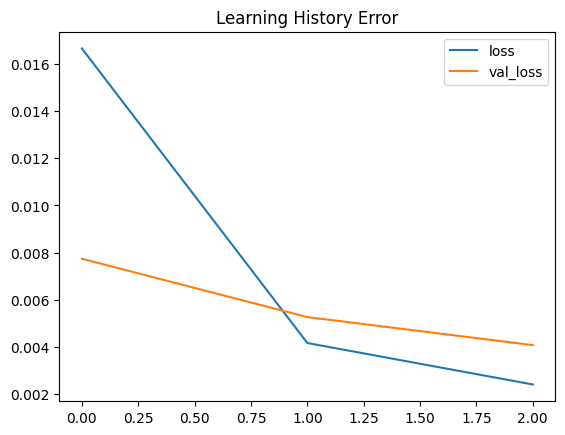

In [20]:
learning_df[["loss","val_loss"]].plot(title="Learning History Error")

<Axes: title={'center': 'Learning History Accuracy'}>

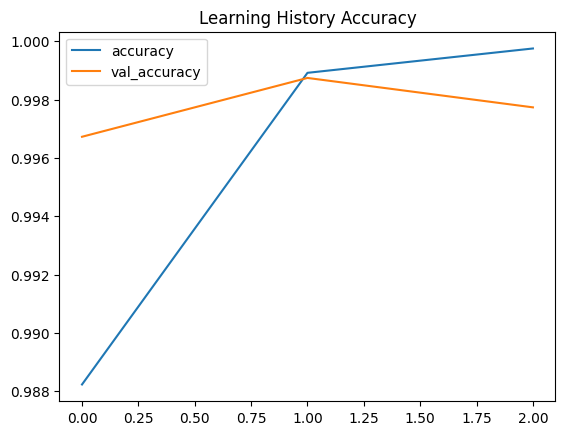

In [21]:
learning_df[["accuracy","val_accuracy"]].plot(title="Learning History Accuracy")

In [22]:
# wandb.log({"loss": list(learning_df["loss"]), "val_loss":list(learning_df["val_loss"]), 
#            "accuracy":list(learning_df["accuracy"]), "val_accuracy":list(learning_df["val_accuracy"])})

## Evaluation

### Plot of embeddings of training data

In [23]:
# Create a new model that outputs embeddings
embedding_model = models.Model(inputs=base_model.input, outputs=base_model.output)

In [24]:
def plot_embeddings(embeddings_3d, labels):
    # Plot the embeddings
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    colors = ['red' if label == 3 else 'blue' for label in labels]
    ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors)
    ax.set_title('3D t-SNE visualization of MNIST 3 and 8 embeddings')
    ax.set_xlabel('t-SNE feature 1')
    ax.set_ylabel('t-SNE feature 2')
    ax.set_zlabel('t-SNE feature 3')
    wandb.log({"plot_test_embedding": wandb.Image(fig)})
    plt.show()

### Plot of embeddings of test data

62/62 [==============================] - 1s 11ms/step


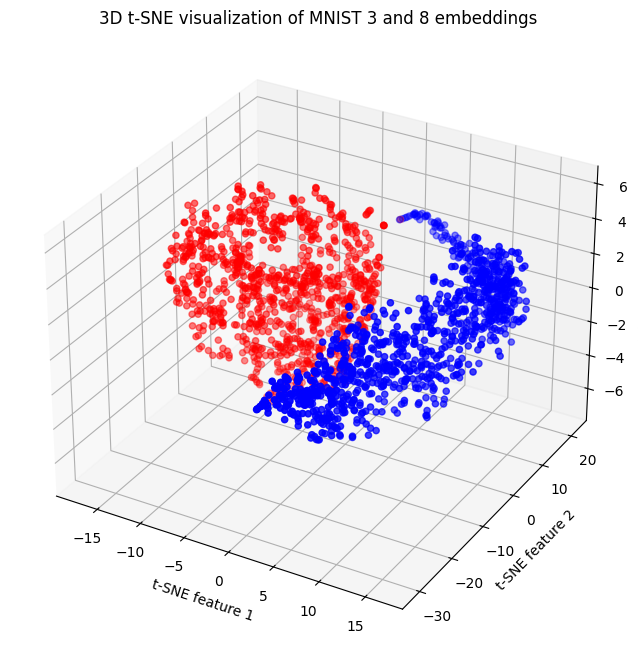

In [25]:
embeddings_test = embedding_model.predict(x_test)
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings_test)
plot_embeddings(embeddings_3d, y_test)

### Evaluation of the model

In [26]:
def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

In [27]:
# Predictions from the model
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])
y_pred = distances_to_labels(distance)

124/124 [==============================] - 2s 17ms/step


In [28]:
def plot_samples_with_predictions(test_pairs, test_labels, predictions, distances, num_samples=5):
    fig = plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        # ax = plt.subplot(num_samples, 2, 2 * i + 1)
        ax = fig.add_subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(test_pairs[i, 0].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = fig.add_subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(test_pairs[i, 1].reshape(28, 28), cmap='gray')
        ax.axis('off')

        label = test_labels[i]
        pred = predictions[i]
        dist = distances[i]
        ax.set_title(f'True: {label}, Pred: {pred}, Dist: {dist:0.15f}')

    wandb.log({"plot_samples_predictions": wandb.Image(fig)})
    plt.tight_layout()
    plt.show()

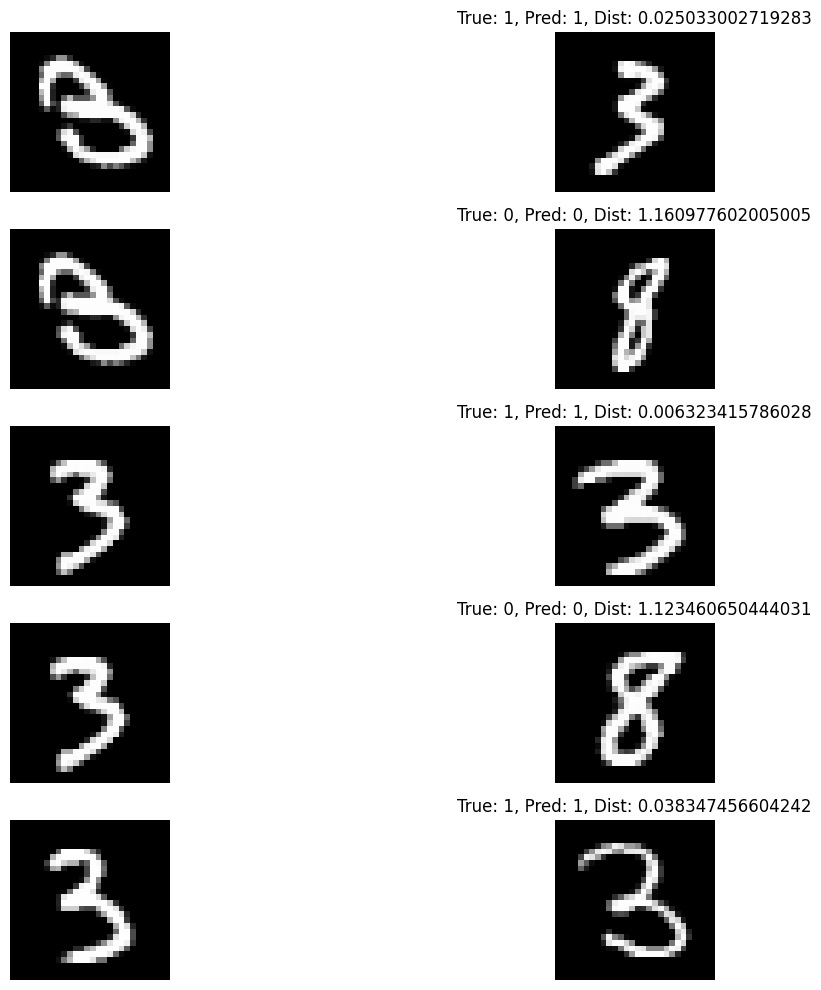

In [29]:
# Plot sample pairs with predictions
plot_samples_with_predictions(pairs_test, labels_test, y_pred, distance, num_samples=5)

In [30]:
def plot_sample_with_embeddings(test_pairs, test_labels, predictions, distances, embedding_model, sample_num=5):
    fig = plt.figure(figsize=(15, 2))
    i = sample_num
    
    # Plot samples with predictions
    ax = plt.subplot(1,2,1)
    plt.imshow(test_pairs[i, 0].reshape(28, 28), cmap='gray')
    ax.axis('off')

    ax = plt.subplot(1,2,2)
    plt.imshow(test_pairs[i, 1].reshape(28, 28), cmap='gray')
    ax.axis('off')

    label = test_labels[i]
    pred = predictions[i]
    dist = distances[i]
    plt.title(f'True: {label}, Pred: {pred}, Dist: {dist:0.15f}')

    wandb.log({"plot_sample_with_embeddings (diff, label=0)": wandb.Image(fig)})
    plt.tight_layout()
    plt.show()

    e = embedding_model.predict(test_pairs[i])
    wandb.log({"sample pair embeddings (diff, label=0)": str(e)})
    print(f"ex {e[0]}\n")
    print(f"ey {e[1]}")

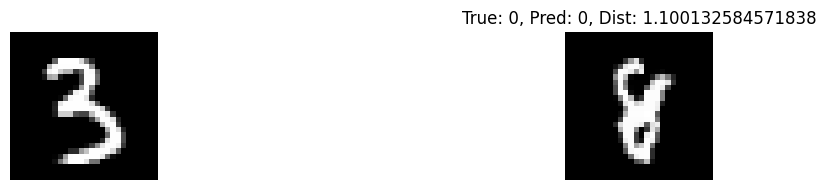

1/1 [==============================] - 0s 145ms/step
ex [0.         0.         0.         0.         0.         0.
 0.         0.05927546 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04236794 0.04979752
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.06465416 0.         0.         0.         0.
 0.         0.         0.         0.        ]

ey [0.         0.20936543 0.         0.2870407  0.         0.
 0.25625393 0.         0.20834607 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.09265236 0.         0.31857255
 0.26257193 0.         0.         0.         0.     

In [31]:
plot_sample_with_embeddings(pairs_test, labels_test, y_pred, distance, embedding_model, sample_num=5)

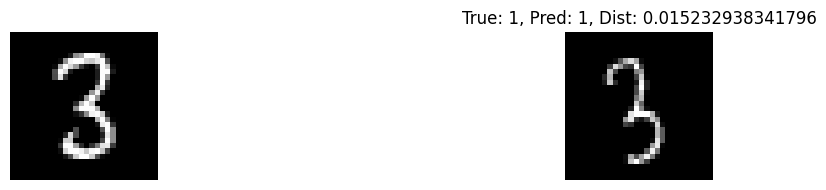

1/1 [==============================] - 0s 57ms/step
ex [0.         0.         0.         0.         0.         0.
 0.         0.04424601 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02827921 0.04619814
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.0521528  0.         0.         0.         0.
 0.         0.         0.         0.        ]

ey [0.         0.         0.         0.         0.         0.
 0.         0.04862956 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.03434243 0.033

In [32]:
plot_sample_with_embeddings(pairs_test, labels_test, y_pred, distance, embedding_model, sample_num=100)

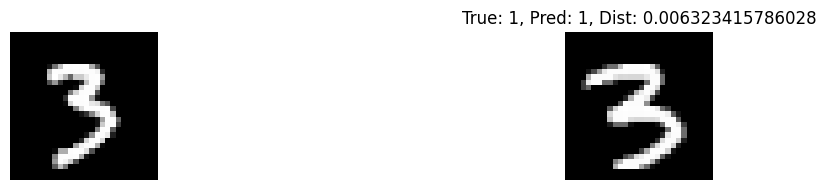

1/1 [==============================] - 0s 43ms/step
ex [0.         0.         0.         0.         0.         0.
 0.         0.05808468 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.04621736 0.05226338
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.05342962 0.         0.         0.         0.
 0.         0.         0.         0.        ]

ey [0.         0.         0.         0.         0.         0.
 0.         0.0638459  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.0482404  0.053

In [33]:
plot_sample_with_embeddings(pairs_test, labels_test, y_pred, distance, embedding_model, sample_num=2)

### Precision, Recall, Accuracy

In [34]:
def evaluate_precision_recall_accuracy(y_true, y_pred, threshold=0.5):
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    true_positives = np.sum((y_true == 1) & (y_pred_binary == 1))
    false_positives = np.sum((y_true == 0) & (y_pred_binary == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_binary == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_binary == 0))
    
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    accuracy = (true_positives + true_negatives) / len(y_true)
    
    return precision, recall, accuracy

In [35]:
wandb.log({"precision_recall_accuracy":evaluate_precision_recall_accuracy(labels_test,y_pred)})

### Confusion Matrix

In [36]:
def make_cm(y_true,y_pred,classes=None,figsize=(10,10),text_size=15):
  cm = cmatrix(y_true,tf.round(y_pred))
  cm_norm = cm.astype("float")/cm.sum(axis=1)[:,np.newaxis] # normalise confusion matrix
  n_class = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm,cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels=classes
  else:
    labels=np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix", 
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_class),
        yticks=np.arange(n_class),
        xticklabels=labels,
        yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)


  threshold = (cm.max()+cm.min())/2

  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,f"{cm[i,j]} ({cm_norm[i,j]*100:.1f})%",
            horizontalalignment="center",
            color="white" if cm[i,j]>threshold else "black",
            size=text_size)
  wandb.log({"Confusion Matrix": wandb.Image(fig)})

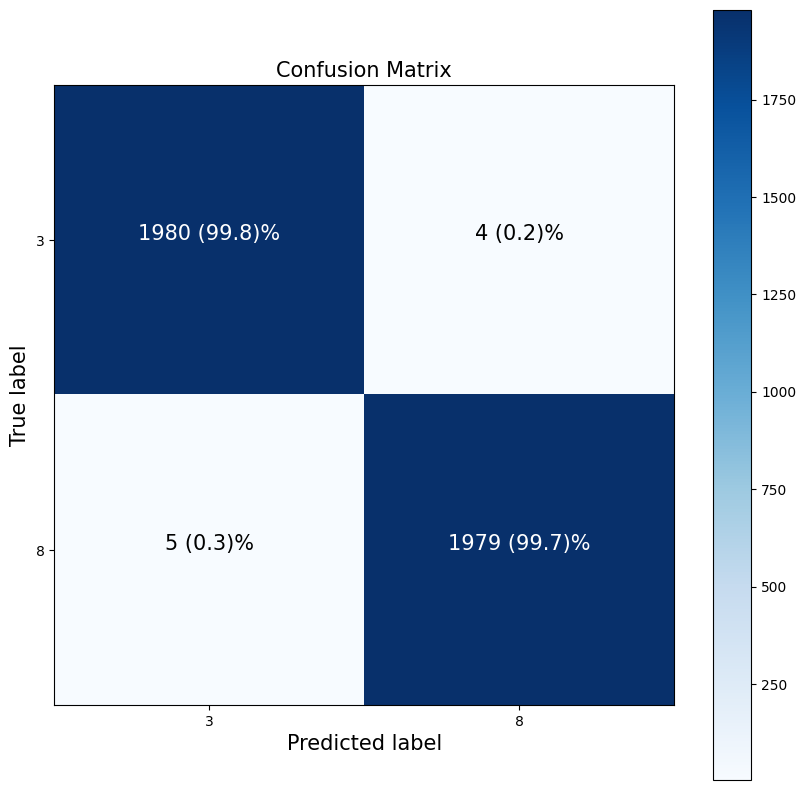

In [37]:
make_cm(labels_test,y_pred,["3","8"])

### AUC-ROC: Area Under the Receiver Operating Characteristic curve 

We see that precision, recall and accuracy; all have very high values indicating that the model worked well on MNIST data.

This is further put to a visual understanding using the confusion matrix above, which clearly shows that the model predicts the correct label on test pairs most of the time.

And the ROC curve below, suggests the same with area being 1.

In [38]:
def plot_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # wandb.log({"roc" : wandb.plot.roc_curve( fpr, tpr,
    #                     labels=None, classes_to_plot=None)})

    
    fig = plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    wandb.log({"AUC-ROC": wandb.Image(fig)})
    
    plt.show()


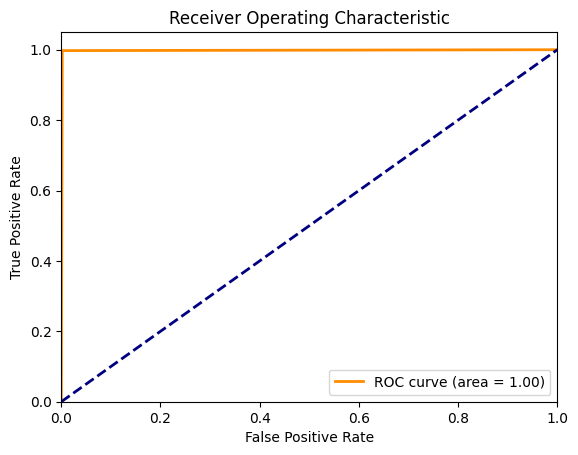

In [39]:
plot_auc(labels_test,y_pred)

In [40]:
# wandb.log({"roc" : wandb.plot.roc_curve(labels_test, y_pred,labels=None, classes_to_plot=None)})

### Saving and Loading the model

In [41]:
# save the model
saved_model_path = '../../saved_models/classical_base_model_1.keras'
siamese_network.save(saved_model_path)
# Load the model
custom_objects={"contrastive_loss": contrastive_loss, "training_accuracy":training_accuracy}
loaded_model = tf.keras.models.load_model(saved_model_path, safe_mode=False, custom_objects=custom_objects)
# Verify
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 64)                   514496    ['input_2[0][0]',             
                                                                     'input_3[0][0]']             
                                                                                                  
 lambda (Lambda)             (None,)                      0         ['sequential[0][0]',      

In [42]:
wandb.finish()

batch/accuracy,▁▆▇▇▇▇▇█████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁▁▁
epoch/loss,█▂▁
epoch/val_accuracy,▁█▅
epoch/val_loss,█▃▁
batch/accuracy,0.99975
